In [95]:
import numpy as np
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from ase.io import read, write
from rascal.representations import SphericalInvariants as SOAP
from sklearn.kernel_ridge import KernelRidge
from skcosmo.preprocessing import StandardFlexibleScaler

In [96]:
def center_shifts(s):
    elements = [1, 6, 7]
    names = ['glycine_alpha', 'glycine_beta', 'glycine_gamma']
    for el in elements:
        for name in names:
            s[name][el] = np.mean(s[name][el]) - s[name][el]
    return s


shifts = {
    'glycine_alpha': {
        1: np.array([4.2, 3.1, 8.4]),
        6: np.array([176.5, 43.4]),
        7: np.array([32.3])
    },
    'glycine_beta': {
        1: np.array([2.5, 2.2, 7.4]),
        6: np.array([175.5, 43.2]),
        7: np.array([31.8])
    },
    'glycine_gamma': {
        1: np.array([3.3, 3.1, 8.8]),
        6: np.array([174.5, 42.4]),
        7: np.array([32.9])
    }
}

shifts = center_shifts(shifts)
shifts = center_shifts(shifts)

In [97]:
hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=4,
              max_radial=6,
              max_angular=4,
              gaussian_sigma_constant=0.5,
              gaussian_sigma_type="Constant",
              cutoff_function_type="RadialScaling",
              cutoff_smooth_width=0.5,
              cutoff_function_parameters=
                    dict(
                            rate=1,
                            scale=3.5,
                            exponent=4
                        ),
              radial_basis="GTO",
              normalize=True,
              optimization=
                    dict(
                            Spline=dict(
                               accuracy=1.0e-05
                            )
                        ),
              compute_gradients=False
              )

soap = SOAP(**hypers)

In [98]:
path_to_file = "PI_NVT/glycine_shieldings/"
path_to_init_file = "PI_NVT/"

In [99]:
base_fn = lambda poly: path_to_file + f'pi_nvt_lmp_glycine_{poly}_300K_00_w_cs.xyz'
alpha_traj = read(base_fn('alpha'),':')
gamma_traj = read(base_fn('gamma'),':')
beta_traj = read(base_fn('beta'),':')


base_init_fn = lambda poly: path_to_init_file + f'glycine_{poly}/{poly}_init.xyz'
alpha_shieldings = read(base_init_fn("alpha"), ":" )[0].get_array("shieldings")
beta_shieldings = read(base_init_fn("beta"), ":" )[0].get_array("shieldings")
gamma_shieldings = read(base_init_fn("gamma"), ":" )[0].get_array("shieldings")

In [165]:
def process(traj, shieldings):
    for frame in traj:
        frame.wrap(eps=1E-10)
        frame.set_array("center_atoms_mask", None)

    number = traj[0].numbers
    X = soap.transform(traj).get_features(soap)

    no_atoms = len(number)
    
    X = X.reshape(len(traj), no_atoms, X.shape[1])

    X_averaged = np.mean(X, axis=0)

    output_cs = {}
    output_X = {}

    for species in [1, 6, 7, 8]:
        output_cs[species] = []
        output_X[species] = []
        types = shieldings[np.where(number == species)[0]] 
        for type in np.unique(types):
            output_cs[species].append(np.mean(np.concatenate([frame.arrays['CS'][np.where((np.logical_and(frame.numbers==species, shieldings == type)))[0]] for frame in traj]))) 
            output_X[species].append(np.mean(X_averaged[np.where((np.logical_and(frame.numbers==species, shieldings == type)))[0],:] , axis=0))    
        output_cs[species] = np.array(output_cs[species])
        output_X[species] = np.array(output_X[species])
    return output_cs, output_X 


def pred_3_folds(X_train, X_test, y_train_raw, y_test_raw):
    
    y_scaler = StandardFlexibleScaler(column_wise=True)
    y_train = y_scaler.fit_transform(y_train_raw)
    y_test = y_scaler.transform(y_test_raw)

    alphas = np.logspace(-8, 4)
    errors = np.zeros(len(alphas))
    for ai, alpha in enumerate(alphas):
        reg = KernelRidge(alpha=alpha, kernel="cosine")
        reg.fit(X_train, y_train)
        errors[ai] = mean_squared_error(y_test, reg.predict(X_test))

    return alphas, errors

In [171]:
cs_alpha, X_alpha = process(alpha_traj, alpha_shieldings)
cs_beta, X_beta = process(beta_traj, beta_shieldings)
cs_gamma, X_gamma = process(gamma_traj, gamma_shieldings)

Text(0.5, 1.0, 'H')

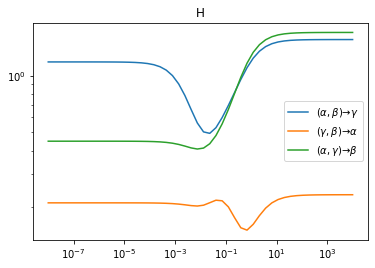

In [203]:
species = 1

csh_alpha = cs_alpha[species].mean() - cs_alpha[species]
csh_gamma = cs_gamma[species].mean() - cs_gamma[species]
csh_beta = cs_beta[species].mean() - cs_beta[species]


delta_alpha = shifts['glycine_alpha'][species] - csh_alpha
delta_gamma = shifts['glycine_gamma'][species] - csh_gamma
delta_beta = shifts['glycine_beta'][species] - csh_beta


plt.loglog(*pred_3_folds(np.array([*X_alpha[species], *X_beta[species]]), X_gamma[species], np.array([*delta_alpha, *delta_beta]).reshape(-1, 1), 
                         delta_gamma.reshape(-1, 1)), label=r'$(\alpha, \beta) \to \gamma$')
plt.loglog(*pred_3_folds(np.array([*X_gamma[species], *X_beta[species]]), X_alpha[species], np.array([*delta_gamma, *delta_beta]).reshape(-1, 1), 
                         delta_alpha.reshape(-1, 1)), label=r'$(\gamma, \beta)\to \alpha$')
plt.loglog(*pred_3_folds(np.array([*X_alpha[species], *X_gamma[species]]), X_beta[species], np.array([*delta_alpha, *delta_gamma]).reshape(-1, 1), 
                         delta_beta.reshape(-1, 1)), label=r'$(\alpha, \gamma) \to \beta$')
plt.legend()
plt.title("H")

Text(0.5, 1.0, 'C')

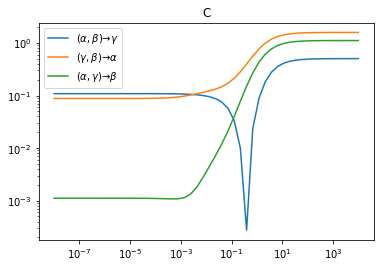

In [204]:
species = 6

csh_alpha = cs_alpha[species].mean() - cs_alpha[species]
csh_gamma = cs_gamma[species].mean() - cs_gamma[species]
csh_beta = cs_beta[species].mean() - cs_beta[species]


delta_alpha = shifts['glycine_alpha'][species] - csh_alpha
delta_gamma = shifts['glycine_gamma'][species] - csh_gamma
delta_beta = shifts['glycine_beta'][species] - csh_beta


plt.loglog(*pred_3_folds(np.array([*X_alpha[species], *X_beta[species]]), X_gamma[species], np.array([*delta_alpha, *delta_beta]).reshape(-1, 1), 
                         delta_gamma.reshape(-1, 1)), label=r'$(\alpha, \beta) \to \gamma$')
plt.loglog(*pred_3_folds(np.array([*X_gamma[species], *X_beta[species]]), X_alpha[species], np.array([*delta_gamma, *delta_beta]).reshape(-1, 1), 
                         delta_alpha.reshape(-1, 1)), label=r'$(\gamma, \beta)\to \alpha$')
plt.loglog(*pred_3_folds(np.array([*X_alpha[species], *X_gamma[species]]), X_beta[species], np.array([*delta_alpha, *delta_gamma]).reshape(-1, 1), 
                         delta_beta.reshape(-1, 1)), label=r'$(\alpha, \gamma) \to \beta$')
plt.legend()
plt.title("C")

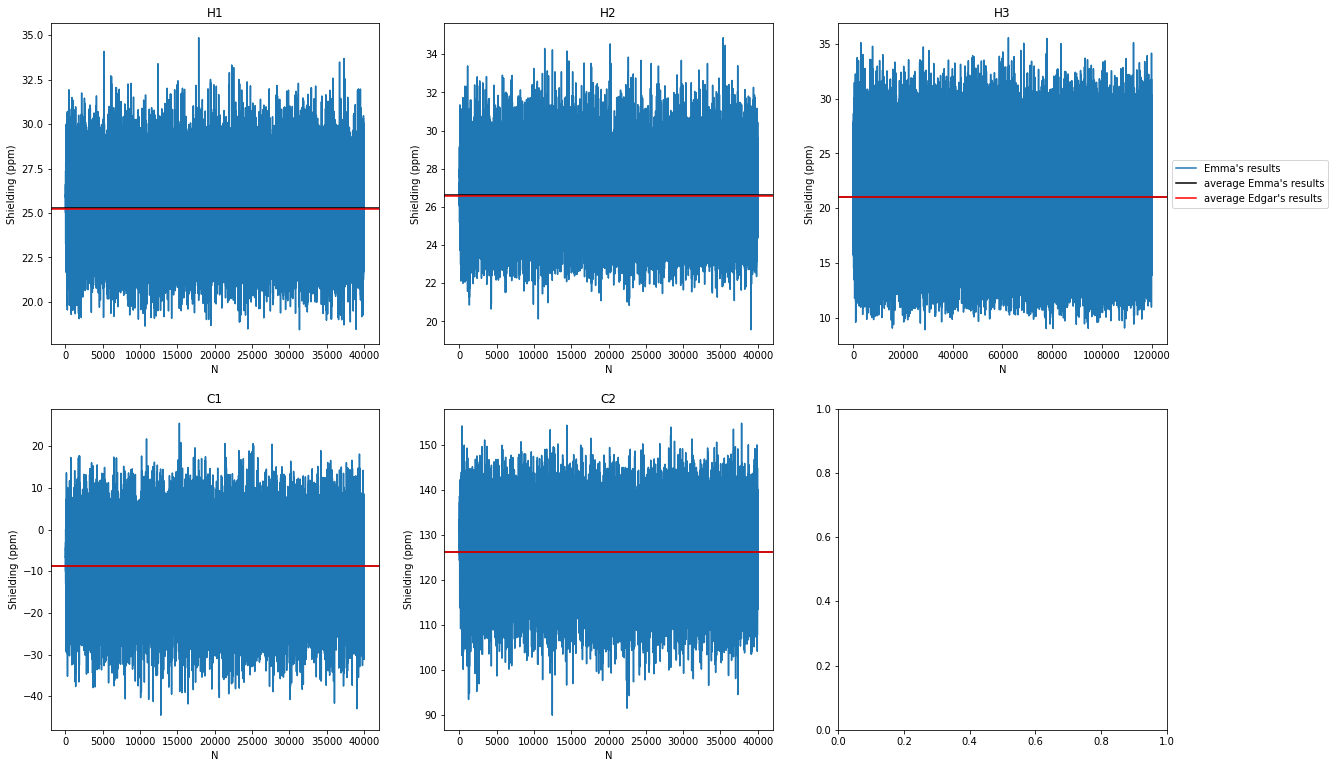

In [201]:
fig, ax = plt.subplots(ncols=3, nrows=2)
fig.set_figheight(13)
fig.set_figwidth(20)

edgars_results = {
    'glycine_alpha': {
        1 : np.array([25.24, 26.59, 21.07]),
        6 : np.array([-8.64, 126.26]),
        7 : np.array([191.82])
    },
    'glycine_beta': {
        1: np.array([26.13, 26.91, 21.16]),
        6: np.array([-5.73, 127.86]),
        7: np.array([194.45])
    },
    'glycine_gamma': {
        1 : np.array([26.53, 27.11, 20.86]),
        6 : np.array([-5.01, 128.34]),
        7 : np.array([191.37])
    }
}

edgars_errors = {
    'glycine_alpha': {
        1 : np.array([0.02, 0.02, 0.01]),
        6 : np.array([0.08, 0.07]),
        7 : np.array([0.15])
    },
    'glycine_beta': {
        1: np.array([0.25, 0.26, 0.21]),
        6: np.array([0.58, 0.64]),
        7: np.array([1.29])
    },
    'glycine_gamma': {
        1 : np.array([0.02, 0.02, 0.01]),
        6 : np.array([0.02, 0.02]),
        7 : np.array([0.01])
    }
}

labels = {1 : "H", 6: "C", 7 : "N", 8 : "O"}

for i, el in enumerate([1,6]):
    for j in range(len(edgars_results["glycine_alpha"][el])):
        cs = np.concatenate([frame.arrays['CS'][np.where(np.logical_and(frame.numbers==el, alpha_shieldings == j + 1))[0]] for frame in alpha_traj])
        ax[i][j].plot(cs, label="Emma's results")
        ax[i][j].axhline(np.mean(cs), c='k', label="average Emma's results")
        ax[i][j].axhline(edgars_results["glycine_alpha"][el][j], c='r', label="average Edgar's results")
        ax[i][j].set_title(labels[el] + str(j + 1))
        ax[i][j].set_ylabel("Shielding (ppm)")
        ax[i][j].set_xlabel("N")
        #ax[i][j].fill_between(range(len(cs[np.where(types==1)])), 25.22, 25.26, color='r', alpha=0.5)
ax[0][2].legend(loc='center left', bbox_to_anchor=(1, 0.5))

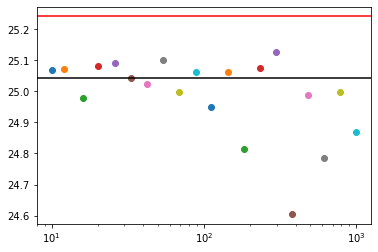

In [71]:
for j in np.logspace(1, 3, 20, dtype=int):
    plt.scatter(j, np.mean(cs[np.where(types==1)][10*j::j]))
plt.axhline(25.24, c='r')
plt.axhline(np.mean(cs[np.where(types==1)]), c='k')
plt.gca().set_xscale('log')